### Step 1 — Setup + Toy “Semantic World” + Fake Encoders

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import random

In [2]:
# -------------------------
# Reproducibility
# -------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# -------------------------
# 1. Define a tiny semantic world
# -------------------------
concepts = [
    "red circle",
    "blue circle",
    "red square",
    "blue square",
    "green circle",
    "green square"
]
num_concepts = len(concepts)
num_concepts

6

In [4]:
# True 2D semantic positions (you can think of this as the "ideal" shared space)
# We'll just place them on a grid-like pattern
semantic_positions = torch.tensor([
    [0.0, 0.0],  # red circle
    [1.0, 0.0],  # blue circle
    [0.0, 1.0],  # red square
    [1.0, 1.0],  # blue square
    [2.0, 0.0],  # green circle
    [2.0, 1.0],  # green square
], dtype=torch.float32, device=device)  # shape: (num_concepts, 2)


In [5]:
# -------------------------
# 2. Define fake "image" and "text" encoders
#    These will be FROZEN (no training).
#    They map the 2D semantic positions into different 8D spaces.
# -------------------------

class FrozenLinearEncoder(nn.Module):
    def __init__(self, in_dim=2, out_dim=8):
        super().__init__()
        # We'll create a random linear layer and then freeze it
        self.linear = nn.Linear(in_dim, out_dim)
        # initialize with random weights
        nn.init.normal_(self.linear.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.linear.bias, mean=0.0, std=0.1)
        # freeze parameters
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        return self.linear(x)

img_encoder = FrozenLinearEncoder(in_dim=2, out_dim=8).to(device)
txt_encoder = FrozenLinearEncoder(in_dim=2, out_dim=8).to(device)

In [6]:
# -------------------------
# 3. Get "image" and "text" features from the same semantic positions
# -------------------------
with torch.no_grad():
    img_feats = img_encoder(semantic_positions)  # (N, 8) on device
    txt_feats = txt_encoder(semantic_positions)  # (N, 8) on device

print("Image feats shape:", img_feats.shape, "device:", img_feats.device)
print("Text feats shape:", txt_feats.shape, "device:", txt_feats.device)

Image feats shape: torch.Size([6, 8]) device: cuda:0
Text feats shape: torch.Size([6, 8]) device: cuda:0


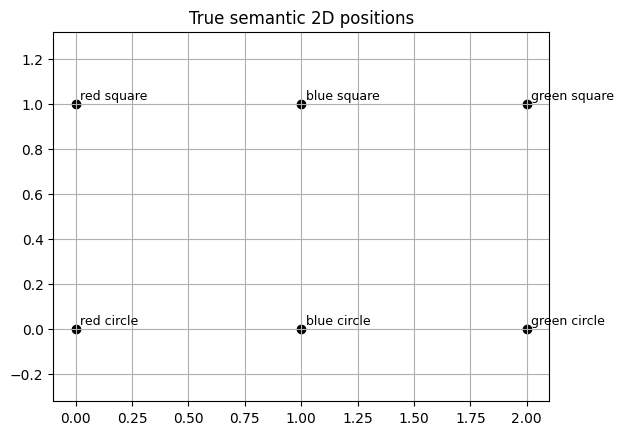

In [7]:
# -------------------------
# 4. Visualize:
#    - (a) The true 2D semantic space
#    - (b) Image features projected to 2D with PCA
#    - (c) Text features projected to 2D with PCA
# -------------------------

def plot_points_2d(points, labels, title, marker, color):
    points = points.cpu().numpy()
    plt.figure()
    for i, (x, y) in enumerate(points):
        plt.scatter(x, y, marker=marker, color=color)
        plt.text(x + 0.02, y + 0.02, labels[i], fontsize=9)
    plt.title(title)
    plt.axis("equal")
    plt.grid(True)
    plt.show()

# (a) True semantic space
plot_points_2d(semantic_positions, concepts, "True semantic 2D positions", marker="o", color="black")


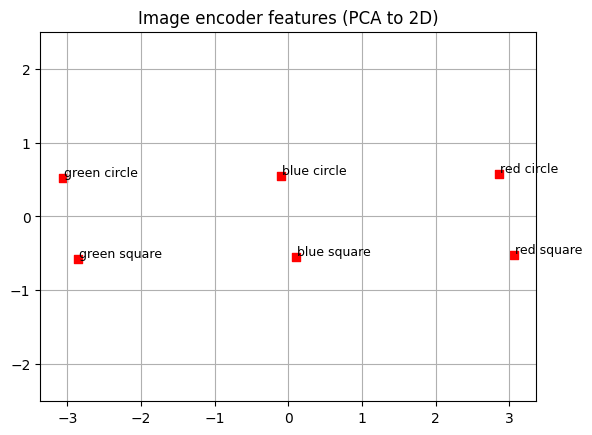

In [8]:
# (b) Image encoder space (PCA to 2D)
pca_img = PCA(n_components=2)
img_2d = torch.from_numpy(pca_img.fit_transform(img_feats.detach().cpu().numpy()))
plot_points_2d(img_2d, concepts, "Image encoder features (PCA to 2D)", marker="s", color="red")


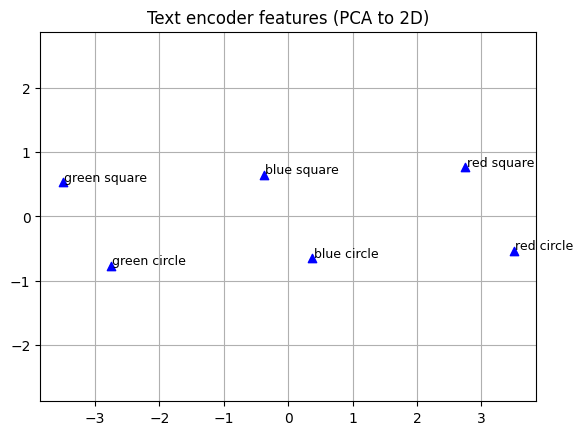

In [9]:
# (c) Text encoder space (PCA to 2D)
pca_txt = PCA(n_components=2)
txt_2d = torch.from_numpy(pca_txt.fit_transform(txt_feats.detach().cpu().numpy()))
plot_points_2d(txt_2d, concepts, "Text encoder features (PCA to 2D)", marker="^", color="blue")

### 🧪 Step 2 — Define Projectors + Contrastive Loss


In [10]:
# -------------------------
# 5. Define trainable projectors for image and text
# -------------------------

class Projector(nn.Module):
    def __init__(self, in_dim=8, out_dim=2, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        z = self.net(x)
        return F.normalize(z, dim=-1)

img_proj = Projector(in_dim=8, out_dim=2).to(device)
txt_proj = Projector(in_dim=8, out_dim=2).to(device)

In [11]:


# -------------------------
# 6. Define a simple contrastive loss (symmetric InfoNCE)
# -------------------------

def contrastive_loss(z_img, z_txt, temperature=0.07):
    """
    z_img: (N, d)
    z_txt: (N, d)
    Returns: scalar loss
    """
    # cosine similarities: (N, N)
    logits = (z_img @ z_txt.t()) / temperature

    # labels: for each i, the positive is at position i
    targets = torch.arange(z_img.size(0), device=z_img.device)

    # image->text loss
    loss_i2t = F.cross_entropy(logits, targets)

    # text->image loss (transpose logits)
    loss_t2i = F.cross_entropy(logits.t(), targets)

    return (loss_i2t + loss_t2i) / 2.0

def total_alignment_loss(z_img, z_txt, temperature=0.07, alpha=1.0):
    # contrastive part (pushes different concepts apart)
    c_loss = contrastive_loss(z_img, z_txt, temperature=temperature)
    # pairwise MSE part (pulls matching image/text together)
    pair_loss = F.mse_loss(z_img, z_txt)
    return c_loss + alpha * pair_loss



In [12]:

# -------------------------
# 7. Quick sanity check: forward through projectors once
# -------------------------
with torch.no_grad():
    z_img_init = img_proj(img_feats)   # both on same device
    z_txt_init = txt_proj(txt_feats)
    init_loss = contrastive_loss(z_img_init, z_txt_init).item()

print("Initial contrastive loss (before training):", init_loss)
print("z_img_init shape:", z_img_init.shape, "device:", z_img_init.device)
print("z_txt_init shape:", z_txt_init.shape, "device:", z_txt_init.device)


Initial contrastive loss (before training): 9.072023391723633
z_img_init shape: torch.Size([6, 2]) device: cuda:0
z_txt_init shape: torch.Size([6, 2]) device: cuda:0


In [13]:
# -------------------------
# 8. Training loop for alignment
# -------------------------

# Make sure projectors are on the correct device
img_proj.to(device)
txt_proj.to(device)

Projector(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [14]:


# Optimizer (only train projectors)
optimizer = torch.optim.Adam(
    list(img_proj.parameters()) + list(txt_proj.parameters()),
    lr=1e-2
)

num_steps = 1000

# Save a copy of initial projected points for plotting later
with torch.no_grad():
    z_img_before = img_proj(img_feats)  # (N, 2)
    z_txt_before = txt_proj(txt_feats)  # (N, 2)

loss_history = []

In [15]:
for step in range(num_steps):
    optimizer.zero_grad()

    z_img = img_proj(img_feats)
    z_txt = txt_proj(txt_feats)

    loss = total_alignment_loss(z_img, z_txt, temperature=0.07, alpha=1.0)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step + 1) % 100 == 0:
        print(f"Step {step+1}/{num_steps} - loss: {loss.item():.4f}")

with torch.no_grad():
    z_img_after = img_proj(img_feats)
    z_txt_after = txt_proj(txt_feats)

print("Training done.")

Step 100/1000 - loss: 1.1216
Step 200/1000 - loss: 0.4447
Step 300/1000 - loss: 0.1290
Step 400/1000 - loss: 0.4504
Step 500/1000 - loss: 0.0200
Step 600/1000 - loss: 0.2650
Step 700/1000 - loss: 0.1683
Step 800/1000 - loss: 0.0394
Step 900/1000 - loss: 0.1475
Step 1000/1000 - loss: 0.0262
Training done.


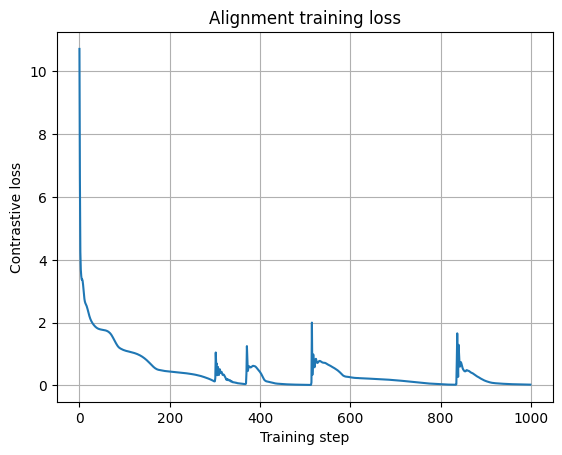

In [16]:
# -------------------------
# 9. Plot loss curve
# -------------------------
plt.figure()
plt.plot(loss_history)
plt.xlabel("Training step")
plt.ylabel("Contrastive loss")
plt.title("Alignment training loss")
plt.grid(True)
plt.show()

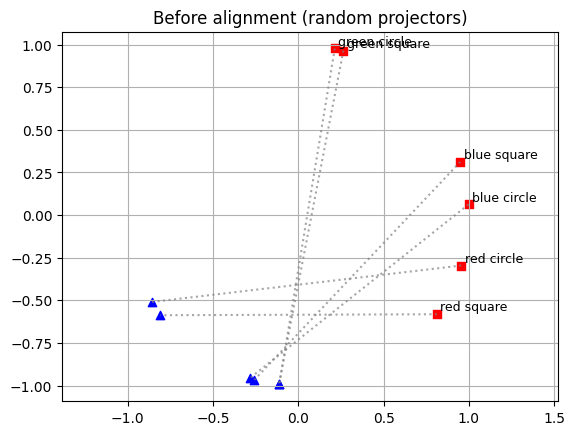

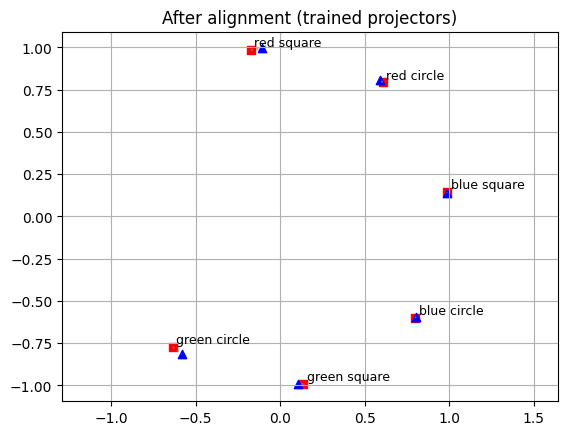

In [17]:


# -------------------------
# 10. Helper plotting function for before/after
# -------------------------

def plot_alignment(z_img, z_txt, labels, title):
    z_img_np = z_img.detach().cpu().numpy()
    z_txt_np = z_txt.detach().cpu().numpy()

    plt.figure()
    for i, name in enumerate(labels):
        xi, yi = z_img_np[i]
        xt, yt = z_txt_np[i]

        # image point
        plt.scatter(xi, yi, marker="s", color="red")
        # text point
        plt.scatter(xt, yt, marker="^", color="blue")

        # draw a line connecting image & text point for same concept
        plt.plot([xi, xt], [yi, yt], color="gray", linestyle="dotted", alpha=0.7)

        # annotate one of them with label
        plt.text(xi + 0.02, yi + 0.02, name, fontsize=9)

    plt.title(title)
    plt.axis("equal")
    plt.grid(True)
    plt.show()

# -------------------------
# 11. Visualize BEFORE and AFTER alignment
# -------------------------
plot_alignment(z_img_before, z_txt_before, concepts, "Before alignment (random projectors)")
plot_alignment(z_img_after, z_txt_after, concepts, "After alignment (trained projectors)")
